In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
from torchmetrics import Dice, JaccardIndex

In [2]:
# config
LEARNING_RATE = 1e-5
SPLIT=0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 15
NUM_WORKERS = 4
IMAGE_HEIGHT = 190
IMAGE_WIDTH = 190
PIN_MEMORY = True

TRAIN_IMG_DIR = 'D:/large_datasets/ultrasound-nerve-segmentation/image'
TRAIN_MASK_DIR = 'D:/large_datasets/ultrasound-nerve-segmentation/mask'


In [3]:
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)


# def crop_img(tensor, target_tensor):
#     target_size = target_tensor.size()[2]
#     tensor_size = tensor.size()[2]
#     delta = tensor_size-target_size
#     delta = delta//2
#     # all batch, all channels, heightModified,widthModified

#     return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)
        x1 = self.down_conv_1(image)
        # print("x1 "+str(x1.shape))
        x2 = self.max_pool_2x2(x1)
        # print("x2 "+str(x2.shape))
        x3 = self.down_conv_2(x2)
        # print("x3 "+str(x3.shape))
        x4 = self.max_pool_2x2(x3)
        # print("x4 "+str(x4.shape))
        x5 = self.down_conv_3(x4)
        # print("x5 "+str(x5.shape))
        x6 = self.max_pool_2x2(x5)
        # print("x6 "+str(x6.shape))
        x7 = self.down_conv_4(x6)
        # print("x7 "+str(x7.shape))
        x8 = self.max_pool_2x2(x7)
        # print("x8 "+str(x8.shape))
        x9 = self.down_conv_5(x8)
        # print("x9 "+str(x9.shape))

        # decoder (transposed convolutions increase the size)
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        # print(x.shape)
        return x.to(DEVICE)


# if __name__ == "__main__":
#     image = torch.rand((3, 3, 572, 572))
#     model = UNet()
#     print(image.shape)
#     model(image)


In [4]:
class UltrasoundDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".tif","_mask.tif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            
        return {"image":image,"mask":mask}

In [5]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

In [6]:
images[115], images[115].replace(".tif","_mask.tif")

('10_95.tif', '10_95_mask.tif')

(420, 580, 3)


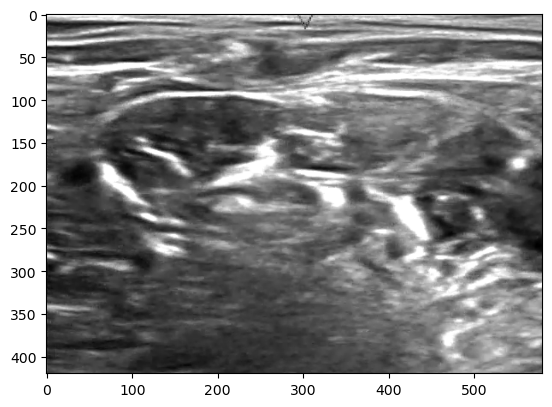

In [7]:
img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images[115]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)

(420, 580)


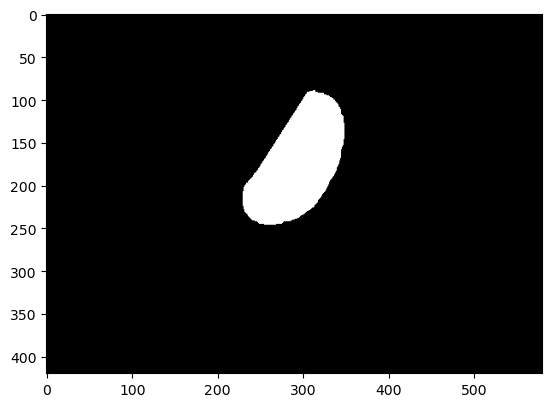

In [8]:
msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+images[115].replace(".tif","_mask.tif")).convert("L"))
plt.imshow(msk,cmap="gray")
print(msk.shape)

In [17]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss
def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    ddice = JaccardIndex(num_classes=2)
    valid_running_loss = 0.0
    dice_overall = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            loss = criterion(outputs,mask)
            valid_running_loss += loss.item()
            #calculate dice coef for each image
            dice_batch = 0.0
            for k in range(mask.shape[0]):
                target = mask[k].int().cpu()
                pred = outputs[k].cpu()
                dice_batch += ddice(pred, target)
            dice_batch = dice_batch / dataloader.batch_size
            dice_overall += dice_batch
    valid_loss = valid_running_loss/counter
    dice_overall = dice_overall/counter
    return valid_loss, dice_overall
    

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 

In [19]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [20]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

In [21]:
train_images_path,val_images_path = train_test_split(images,SPLIT)
train_data = UltrasoundDataset(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = UltrasoundDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

In [22]:
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [23]:
# Val Loss: 0.6500
# Dice Coefficient: 0.0000

In [ ]:
train_loss = []
val_loss = []
dice = []
val_loss_min = 0.022

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data, optimizer, criterion)
    val_epoch_loss, dice_coef_ = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    dice.append(dice_coef_)
    if val_epoch_loss <= val_loss_min:
            print('val_epoch_loss metrics improved ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_epoch_loss))
            torch.save(model.state_dict(), 'UNET_ultra.pt')
            val_loss_min = val_epoch_loss
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'Dice Coefficient: {dice_coef_:.4f}')
    
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.plot(dice, color="blue", label='dice coefficient')
plt.xlabel("Epochs")
plt.ylabel("Loss, Metrics")
plt.legend()
# plt.savefig(f"../input/loss.png")
plt.show()
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./model.pth")

print("\n---------DONE TRAINING----------\n")

In [25]:
model.load_state_dict(torch.load('UNET_ultra.pt'))

<All keys matched successfully>

In [26]:
val_epoch_loss, dice_coef_ = validate(model, valid_dataloader, valid_data, criterion)
print(f'Val Loss: {val_epoch_loss:.4f}')
print(f'Dice Coefficient: {dice_coef_:.4f}')


--------Validating---------



71it [00:26,  2.64it/s]                                                                                                

Val Loss: 0.0229
Dice Coefficient: 0.5278


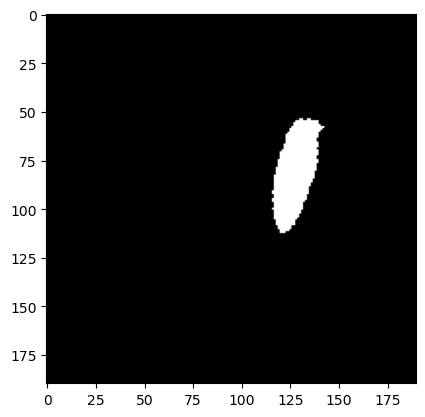

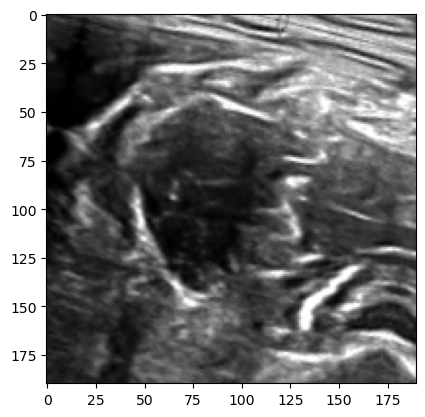

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


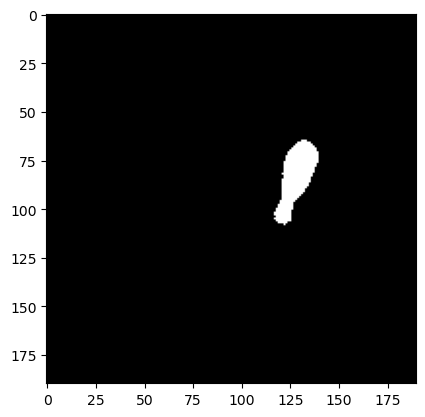

In [29]:
data = train_data.__getitem__(1159)
plt.imshow(data['mask'],cmap="gray")
plt.show()
# for Testing on Single datapoint after training
# plt.imshow(np.transpose(np.array(data['image']),(1,2,0)),cmap="gray")
img = data['image'].unsqueeze(0).to(device="cuda")
plt.imshow(data['image'][0],cmap="gray")
plt.show()
# model = UNet()
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")

In [30]:
model = UNet().to(DEVICE)

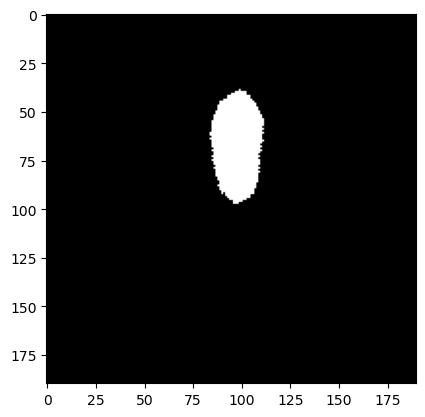

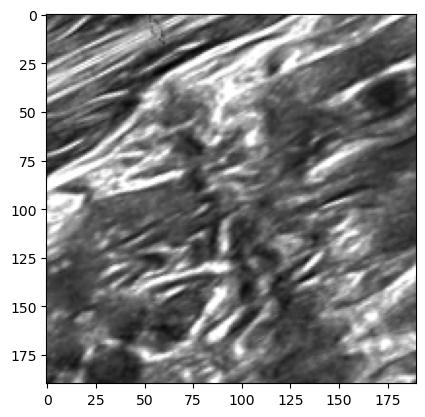

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


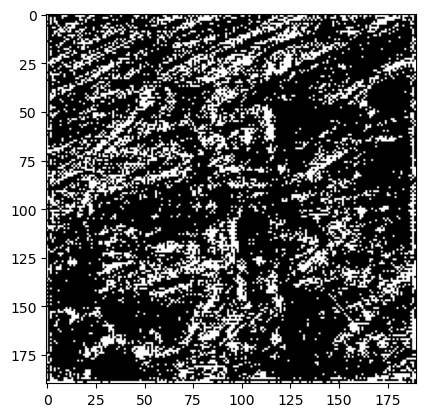

In [31]:
data = train_data.__getitem__(175)
plt.imshow(data['mask'],cmap="gray")
plt.show()
# for Testing on Single datapoint after training
# plt.imshow(np.transpose(np.array(data['image']),(1,2,0)),cmap="gray")
img = data['image'].unsqueeze(0).to(device="cuda")
plt.imshow(data['image'][0],cmap="gray")
plt.show()
# model = UNet()
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")